In [1]:
### replicate results of EVmutation with the PABP_YEAST dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy
from collections import OrderedDict
from sklearn.svm import OneClassSVM
from datetime import datetime


In [2]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
np.random.seed(0)

In [3]:
# helper functions
def encode(seqs, alphabet=ALPHABET_PROTEIN):
    '''
    Go from letters to numbers
    '''
    aa_to_i = OrderedDict((aa, i) for i, aa in enumerate( alphabet ))
    X = np.asarray([[aa_to_i[x] for x in seq] 
                    for seq in seqs])
    return X, aa_to_i
def one_hot_encode(s):
    return np.vstack([np.zeros(20), np.eye(20)])[s].flatten()

def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True
def process_msa_sequence(msa_sequences):
    ''' takes in list of sequences and one-hot encodes the sequences'''
    pos_upper = [x for x in range(len(msa_sequences[0])) if not msa_sequences[0][x].islower()]
    msa_sequences = np.asarray([np.asarray(list(s))[pos_upper] for s in msa_sequences if not 'x' in s])
    msa_sequences = np.asarray([s for s in msa_sequences if check_sequence(s) and len(s)==82])
    msa_sequences = np.asarray(msa_sequences)

    seqs_enc, aa_to_i = encode(msa_sequences)
    oh_enc_seq = []
    for s in seqs_enc:
        oh_enc_seq.append(one_hot_encode(s))
    oh_enc_seq = np.asarray(oh_enc_seq)
    return oh_enc_seq

def valid_weights_from_model(c):
    ### returns only valid weights
    _w = c.weights
    _w_valid = []
    for i in range(c.weights.shape[0]):
        if _w[i] == 0: 
            continue
        _w_valid.append(1/_w[i])
    return _w_valid
    
def unison_shuffled_copies(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [4]:
### get all available msa sequences
yeast_seq_str = []
fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
for fasta in fasta_sequences:
    yeast_seq_str.append(str(fasta.seq))

processed = process_msa_sequence(yeast_seq_str)
c = CouplingsModel(f"PABP_YEAST/model/PABP_YEAST.model_params")
weights = valid_weights_from_model(c)
assert len(weights) == len(processed)
wildtype_processed, wildtype_weights = processed[0], weights[0]
processed, weights = np.asarray(processed[1:]), np.asarray(weights[1:])
processed, weights = unison_shuffled_copies(processed, weights)

In [5]:
# using the trained svm model on DMS data
wildtype = yeast_seq_str[0]
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
mutant, label_dms = data['mutant'].to_numpy(), data['linear'].to_numpy()
mutant_data = []
for m in mutant:
    original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
    assert wildtype[loc] == original_aa
    mutant_data.append(wildtype[:loc]+mutant_aa+wildtype[loc+1:])
mutant_data = np.asarray(mutant_data)
mutant_data = process_msa_sequence(mutant_data)

mutant_data, label_dms = np.asarray(mutant_data), np.asarray(label_dms)
mutant_data, label_dms = unison_shuffled_copies(mutant_data, label_dms)

label = np.zeros(label_dms.shape[0])
for i in range(label_dms.shape[0]):
    label[i] = 1 if label_dms[i] > 0.6 else 0


(1671,)
kernel: poly deg 2, nu: 1.56e-06, result:  770
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1]
1054
SpearmanrResult(correlation=0.25611327515118765, pvalue=3.012540239362314e-19)


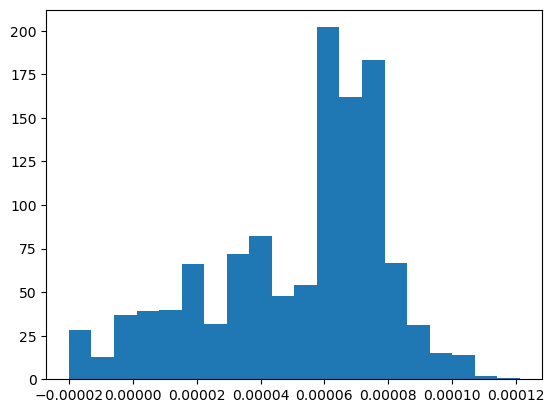

(1798,)
kernel: poly deg 2, nu: 2e-06, result:  772
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1134
SpearmanrResult(correlation=0.25346168340624037, pvalue=7.169356693021515e-19)


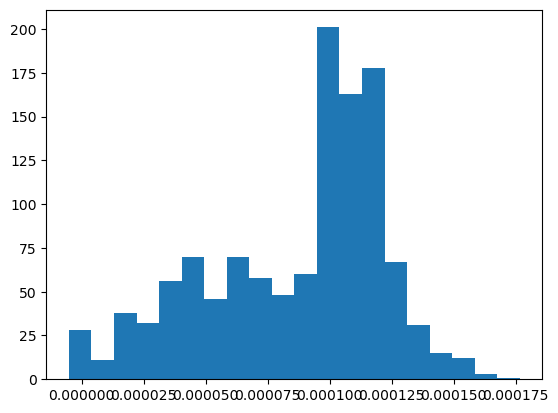

(4895,)
kernel: poly deg 2, nu: 1e-05, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.28765507213567193, pvalue=4.554811184816705e-24)


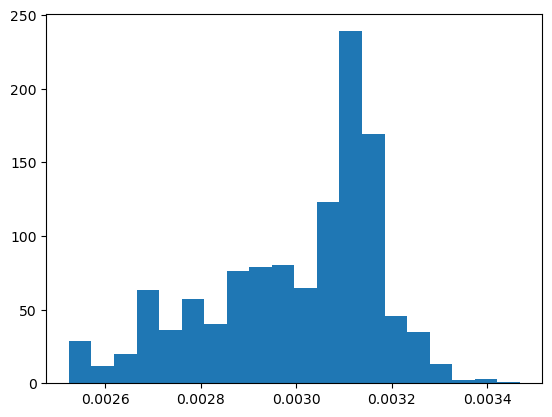

(4966,)
kernel: poly deg 2, nu: 2e-05, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.28534222910785184, pvalue=1.0807592444243968e-23)


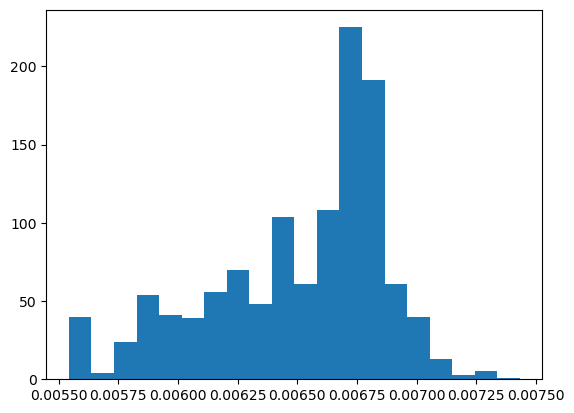

(4987,)
kernel: poly deg 2, nu: 0.0001, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.2849690051485204, pvalue=1.2415258076985135e-23)


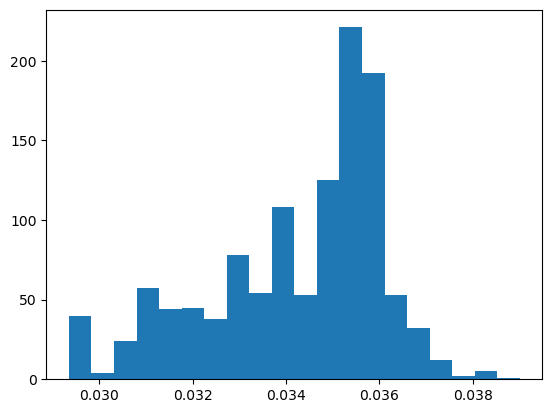

(4988,)
kernel: poly deg 2, nu: 0.0002, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.28351226040567173, pvalue=2.128909712258568e-23)


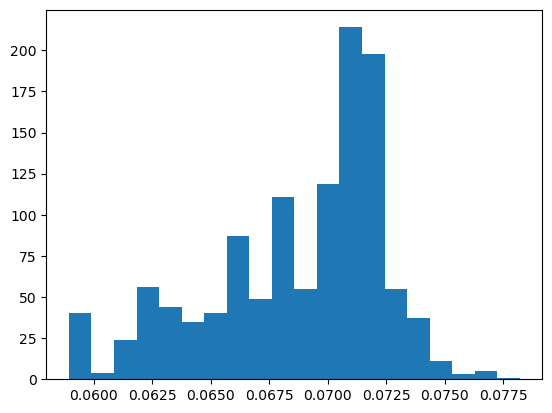

(4989,)
kernel: poly deg 2, nu: 0.001, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.285807052899078, pvalue=9.090613348041927e-24)


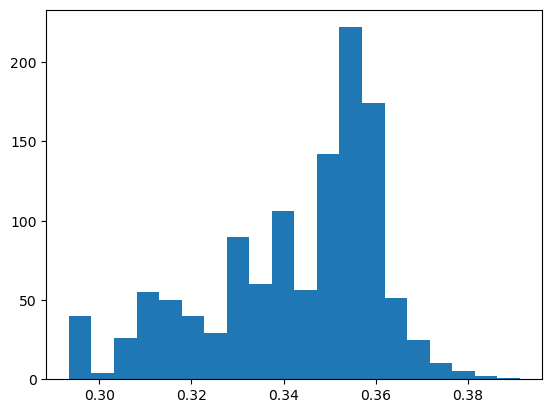

(4985,)
kernel: poly deg 2, nu: 0.002, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.2836957561167048, pvalue=1.9894494353846846e-23)


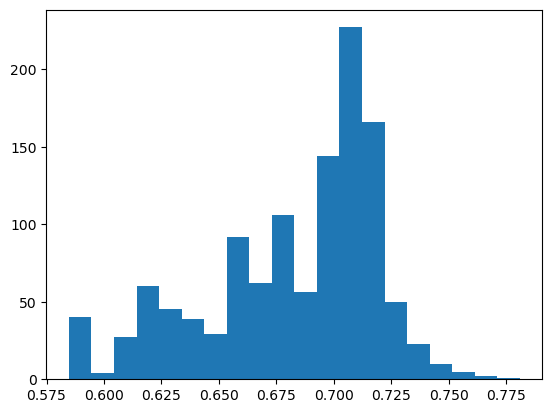

(4973,)
kernel: poly deg 2, nu: 0.01, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.2721362154937031, pvalue=1.287401110362693e-21)


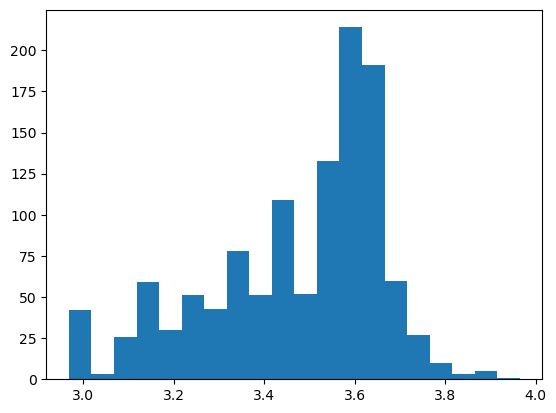

(4955,)
kernel: poly deg 2, nu: 0.02, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.27055260354284566, pvalue=2.2444705689488758e-21)


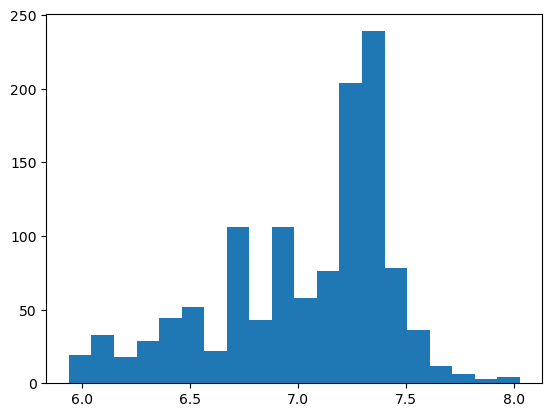

(4714,)
kernel: poly deg 2, nu: 0.1, result:  751
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
SpearmanrResult(correlation=0.2791225806004685, pvalue=1.060534174242167e-22)


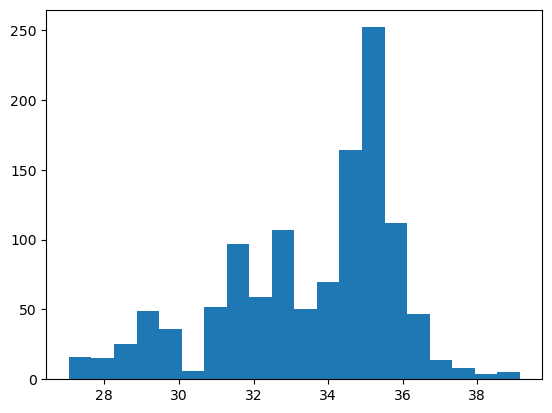

In [10]:
# train a linear model, which should theoretically be similar to the potts model.

with open('result.txt', 'a') as file:
    file.write("Polynomial degree 2 kernel no expansion")
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    for n in [0.00000156, 0.000002, 0.00001, 0.00002, 0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02, 0.1 ,0.2 ,0.3 ,0.5, 0.7, 0.9]:
        clf = OneClassSVM(kernel='poly', degree=2, nu=n)
        clf.fit(processed[:140000], sample_weight=weights[:140000])
        pred_msa = clf.predict(processed[140000:145000])
        print(pred_msa[np.where(pred_msa==1)].shape)
        pred = clf.predict(mutant_data)
        cnt = 0 
        for i in range(mutant_data.shape[0]):
            if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
                cnt += 1
        print(f'kernel: poly deg 2, nu: {n}, result: ', cnt)
        file.write(f'kernel: poly deg 2, nu: {n}, result: {cnt}\n')
        print(pred[:20])
        file.write('\n')
        print(np.sum(pred))
        file.write(f'Sum: {np.sum(pred)}\n')
        print(scipy.stats.spearmanr(clf.decision_function(mutant_data), label_dms))
        plt.hist(clf.decision_function(mutant_data), bins=20)
        plt.show()
